In [32]:
import pandas as pd
from sklearn.linear_model import LinearRegression

# Загрузка данных

In [33]:
%%capture
!wget https://www.dropbox.com/s/64ol9q9ssggz6f1/data_ford_price.xlsx

In [34]:
data = pd.read_excel('data/data_ford_price.xlsx') 

Обратимся к нашим данным. Нас просят предсказать цену автомобиля. Для обучения модели выделим целевой столбец:

In [35]:
y = data['price']
X = data.drop(columns='price')

# Предобработка

Попробуем применить линейную регрессию на «сырых» данных:

In [36]:
#lr = LinearRegression()
#lr.fit(X,y)

Мы получим ошибку с комментарием о том, что не удалось превратить строковое значение в число с плавающей точкой (float).
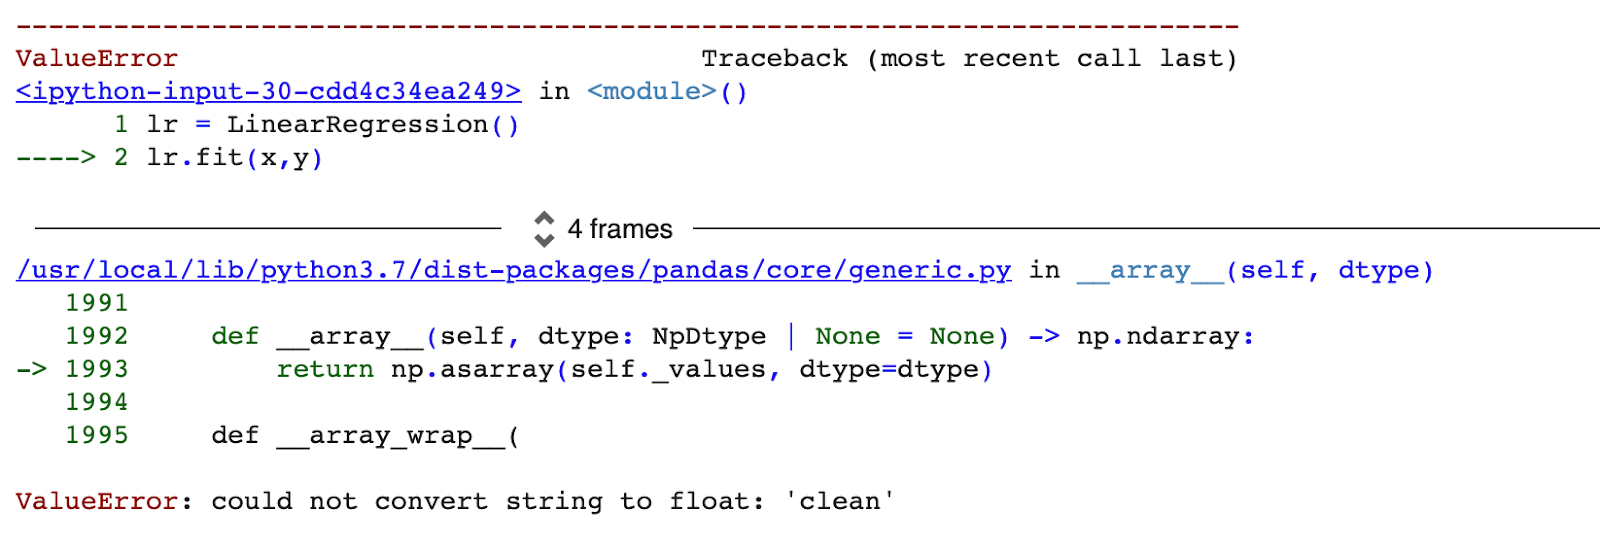

Чтобы этой ошибки не возникало, необходимо закодировать данные.

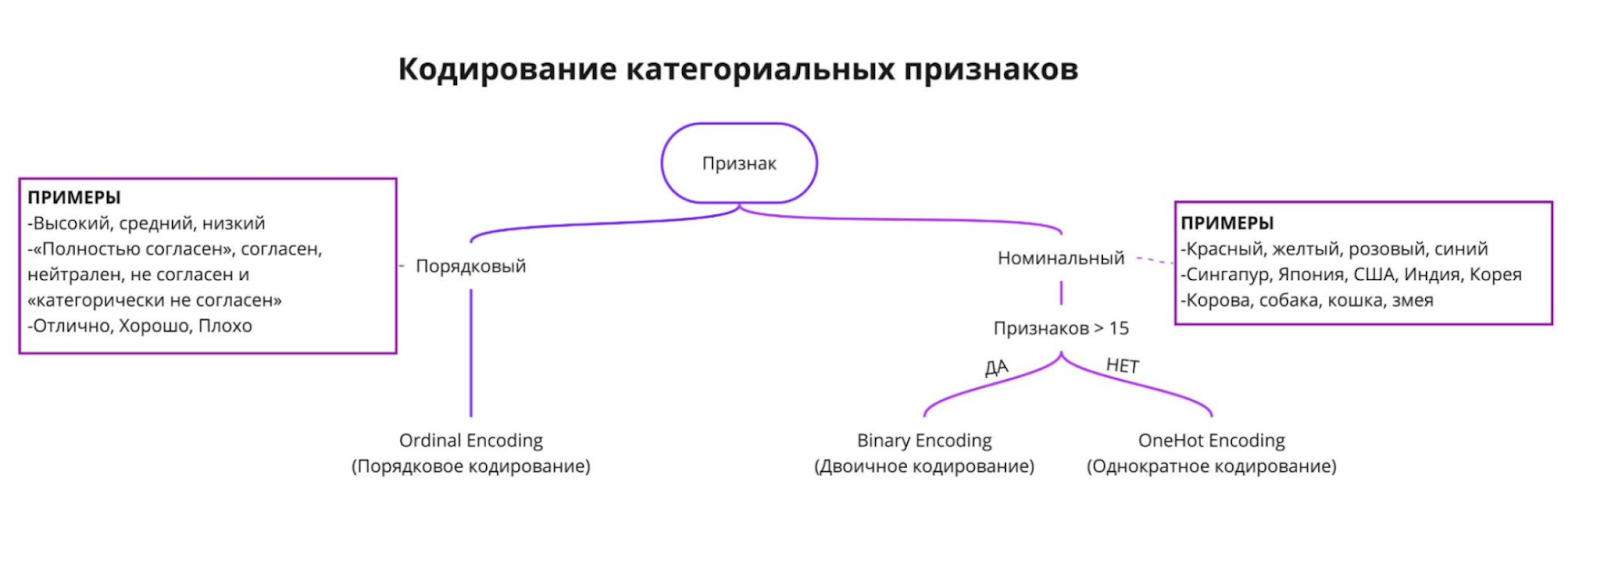

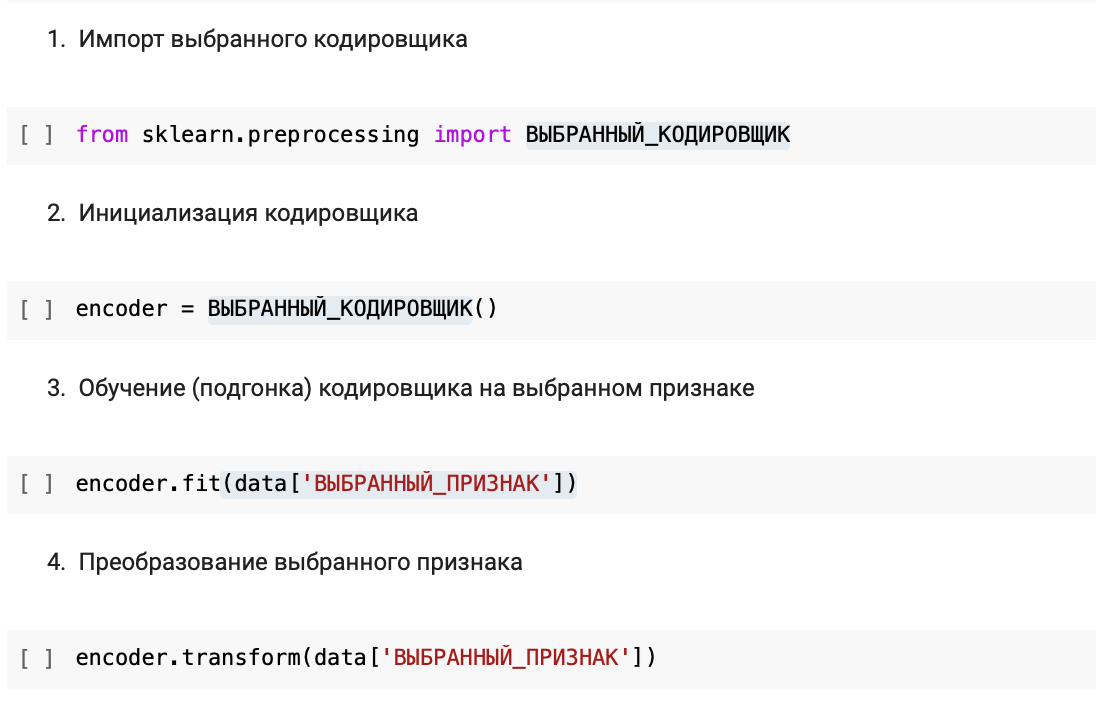 


При решении задач машинного обучения данные разбираются на обучающую (train) и валидационную (validation) выборки (последняя также может быть тестовой (test) выборкой). По аналогии подгонка кодировщика происходит на обучающей выборке, а трансформация — на обучающей и на тестовой.

Почему так? Потому что наша обученная модель не должна видеть данные, которые подаются в неё на тесте. Только так мы можем судить о том, что модель обучена качественно. То же самое и с кодировкой.

Давайте посмотрим на кодирование признака Образование способом «один-против-всех» (one vs all):

In [37]:
from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()
 
education = ['нет', 'начальное', 'среднее', 'BSc', 'MSc', 'начальное', 'PhD']
 
lb.fit(education)
 
print('категории:', lb.classes_)
 
lb.transform(['нет', 'MSc'])

категории: ['BSc' 'MSc' 'PhD' 'начальное' 'нет' 'среднее']


array([[0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0]])

У класса LabelBinarizer, как и у двух остальных, есть атрибут classes_, который выводит список уникальных значений признака.

Вернёмся к нашей выборке. В ней присутствуют следующие категориальные признаки: condition, cylinders, title_status, transmission, drive, size.

При этом признаки condition и cylinders — числовые, а title_status, transmission, drive, size — текстовые.

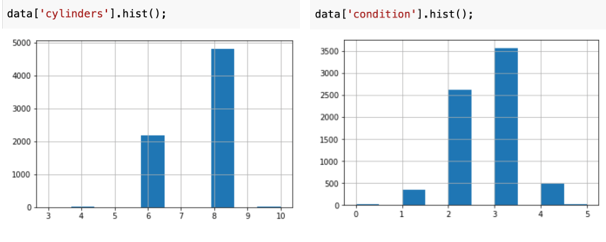

condition — это порядковый признак, который уже представлен в числовом формате, его кодировать не нужно. cylinders — номинальный признак, его нужно закодировать.

Важно производить кодирование номинальных признаков, даже если они уже представлены в числовом формате, так как, в отличие от порядковых признаков, категории номинальных являются независимыми. В случае порядкового кодирования таких признаков мы вносим искусственные закономерности в данные (например, чем больше числовой код цилиндров, тем лучше, хотя это необязательно так).

_______________________
Сторонний пример

In [38]:
from sklearn.preprocessing  import LabelBinarizer
 
lb = LabelBinarizer()
 
education = ['нет', 'начальное', 'среднее', 'BSc', 'MSc', 'начальное', 'PhD']
lb.fit(education)
 
print('категории:', lb.classes_) 
lb.transform(['нет', 'MSc'])

категории: ['BSc' 'MSc' 'PhD' 'начальное' 'нет' 'среднее']


array([[0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0]])

___________________________________

Посмотрим на число уникальных значений номинальных признаков title_status, transmission, drive, size и cylinders:

In [39]:
columns_to_change = ['cylinders', 'title_status', 'transmission', 'drive', 'size']
 
for column in columns_to_change:
 print('Число уникальных значений призкака {}: '.format(column), data[column].nunique())

Число уникальных значений призкака cylinders:  6
Число уникальных значений призкака title_status:  5
Число уникальных значений призкака transmission:  3
Число уникальных значений призкака drive:  3
Число уникальных значений призкака size:  4


Итак, нам подходит однократное кодирование. Применим его к выбранным столбцам. Так как у нас нет отдельной тестовой выборки, то мы используем только один метод — fit_transform(). В качестве аргумента передаём таблицу с выбранными для преобразования признаками.

С помощью метода get_feature_names_out() получим список новых названий колонок:

In [42]:
from sklearn.preprocessing import OneHotEncoder
 
one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(data[columns_to_change]).toarray() 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
print(column_names)

['cylinders_3' 'cylinders_4' 'cylinders_5' 'cylinders_6' 'cylinders_8'
 'cylinders_10' 'title_status_clean' 'title_status_lien'
 'title_status_missing' 'title_status_rebuilt' 'title_status_salvage'
 'transmission_automatic' 'transmission_manual' 'transmission_other'
 'drive_4wd' 'drive_fwd' 'drive_rwd' 'drive_nan' 'size_compact'
 'size_full-size' 'size_mid-size' 'size_sub-compact' 'size_nan']


Отлично, категориальные признаки закодированы. Теперь нам необходимо соединить преобразованные данные с исходными.

Напомним, что у библиотеки pandas есть дефолтный метод get_dummies() для получения однократного кодирования признаков. Однако OneHotEncoder способен принимать на вход как таблицы, так и numpy-массивы.

In [43]:
data_onehot = pd.DataFrame(data_onehot, index=data.index, columns=column_names)

In [44]:
data_new = pd.concat([data, data_onehot], axis=1)

In [45]:
data_new = data_new.drop(columns=columns_to_change)

In [46]:
data_new.shape

(7017, 30)